# Will it Rain?

Data sourced from : https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## Binary classification implemented with logistic regression which uses meteorological data to predict wheather it will rain 

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt  
import seaborn as sns

### Importing data and converting 'yes' it will rain to 1 and 'no' it will not rain to 0

In [620]:
data = pd.read_csv('weatherAUS.csv')
data.loc[data.RainTomorrow == 'No', 'RainTomorrow'] = 0
data.loc[data.RainTomorrow == 'Yes', 'RainTomorrow'] = 1
data.loc[data.RainToday == 'No', 'RainToday'] = 0
data.loc[data.RainToday == 'Yes', 'RainToday'] = 1

In [561]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0,0.0,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0,1.0,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0.2,0


## Covariance - shows correlation between features

In [188]:
clean = data.RainToday.notna()
(data.RainToday.loc[clean]).shape


(140787,)

In [104]:
covariance = np.cov(data_nums.T)
corr = np.corrcoef(data_nums.T)

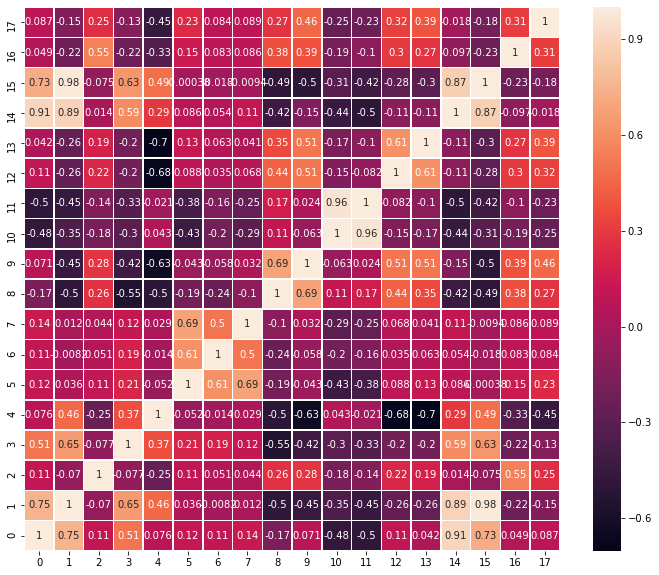

In [107]:
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)
plt.xlim(0,18)
plt.ylim(0,18)
plt.show()

### How many null (nan) values for each feature?

In [174]:
data.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

## Determining importance of features

#### Since some features have many missing data points it will be helpful to determine the predictive power of each feature to see which ones are most relevant. 

### Drop all non numerical data and the predictions

In [372]:
numdataX = data.drop(['Date', 'Location', 'WindGustDir', 'WindDir9am','WindDir3pm', 'RISK_MM','RainToday','RainTomorrow'], axis=1)
numdataX_shape = numdataX.shape
n_numX = numdataX_shape[1]

### Calculate the integral (area under curve) of the ROC curve of the rain vs no rain data for each feature. The larger the area the more predictive the feature will be.  

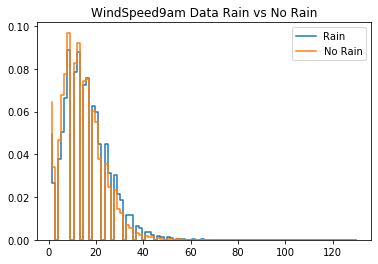

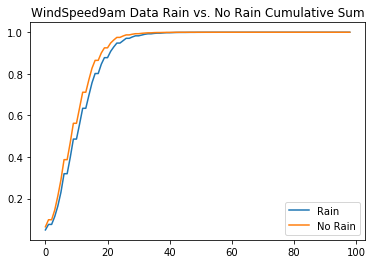

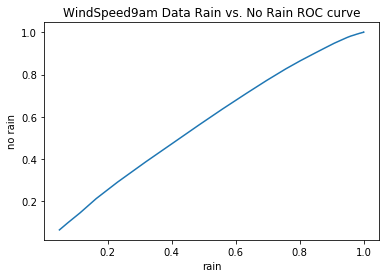

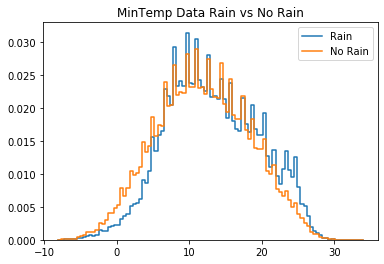

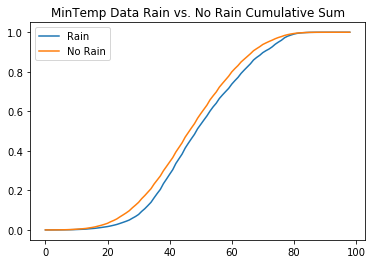

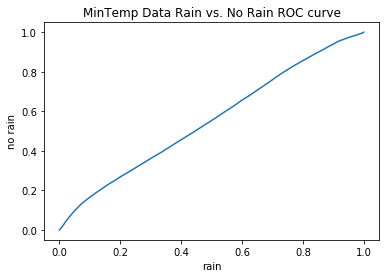

('ROC area:', 0.5239611877877213, 'MinTemp')

In [599]:
mtot = data.shape[0]               # max number of data points

raintomorrow = data.RainTomorrow   # our predictions


def rain_norain_ROC(feature, key, show_plot = True):
    feat_arr = np.asarray(feature)
    feat_arr = feat_arr[np.logical_not(np.isnan(feat_arr))]    # cleans feature data of NaN
    rain = np.asarray([feature[raintomorrow==1]])              # picks out featire data which corresponds to a RainTomorrow =1 
    notrain = np.asarray([feature[raintomorrow==0]])           # picks out featire data which corresponds to a RainTomorrow =0

    rain = rain[np.logical_not(np.isnan(rain))]                # cleans feature-rain data of NaN
    notrain = notrain[np.logical_not(np.isnan(notrain))]       # cleans feature-notrain data of NaN
   
    x = np.linspace(feat_arr.min(), feat_arr.max(), 100)

    y_rain, x_rain = np.histogram(rain , bins= x)              # histogram of feature data that corresponds to rain
    y_rain = y_rain/np.sum(y_rain)                             # normalization 
    y_notrain, x_notrain = np.histogram(notrain , bins= x)     # histogram of feature data that corresponds to no rain
    y_notrain = y_notrain/np.sum(y_notrain)                    # normalization 
   
    
    rain_sum = np.cumsum(y_rain)                               # cumulative sum of rain and not rain feature data
    notrain_sum = np.cumsum(y_notrain)
  

    s = 1-rain_sum                                              # signal and background to calculate ROC curve
    b = 1-notrain_sum
    
    area = np.sum(b)/len(b)                                    # area under ROC curve 
    
    if area < 0.5:                                             # ordering 
        s = rain_sum
        b = notrain_sum
        area = np.sum(b)/len(b)
    else: 
        s = 1-rain_sum
        b = 1-notrain_sum
        area = np.sum(b)/len(b)
    
    if show_plot == True:                         # histogram plot of feature data divided into rain vs no rain 
        title1 = str(key) + " Data Rain vs No Rain"
        plt.title(title1)
        plt.step(x_rain[1:], y_rain, label='Rain')
        plt.step(x_notrain[1:], y_notrain, label='No Rain')
        plt.ylim(bottom=0)
        plt.legend()
        plt.show()
    
        title2 = str(key)+ " Data Rain vs. No Rain Cumulative Sum"
        plt.title(title2)
        plt.plot(s, label='Rain')                 # plot of feature data cumulative sum divided into rain vs no rain
        plt.plot(b, label='No Rain')
        plt.legend()
        plt.show()
    
        title3 =  str(key)+ " Data Rain vs. No Rain ROC curve"
        plt.title(title3)         # plot of ROC curve 
        plt.plot(s, b)
        plt.xlabel('rain')
        plt.ylabel('no rain')
        plt.show()
    return 'ROC area:', area, key

rain_norain_ROC(numdataX.WindSpeed9am, 'WindSpeed9am')
rain_norain_ROC(numdataX.MinTemp, 'MinTemp')

### Predictive power vs number of null entries
#### Calculated the ROC area for each feauture and list it next to number of null entries in total data set. By looking at this the featues with highest predictive power can be chosen. 

In [605]:
def allROC(dataset):
    pred= pd.DataFrame()
    for k,v in dataset.iteritems():
        ROC = rain_norain_ROC(v, k, False)
        numofnan = v.isna().sum()
        df = pd.DataFrame({'Power': ROC[1], 'NaN': numofnan}, index= {k})
        pred =pred.append(df)
    return pred

Power_vs_NaN = allROC(numdataX)
Power_vs_NaN.sort_values(by=['Power'])      # sorted by lowest to highest predictive power 

,Power,NaN
Temp9am,0.507090,904
MinTemp,0.523961,637
Temp3pm,0.528592,2726
MaxTemp,0.536266,322
Humidity3pm,0.540302,3610
Cloud9am,0.563080,53657
Cloud3pm,0.564234,57094
Sunshine,0.584490,67816
Pressure3pm,0.619183,13981
Pressure9am,0.624711,14014


## Data Set Cleaning 

### Only keeping numerical data

In [619]:
numdata = data.drop(['Date', 'Location', 'WindGustDir', 'WindDir9am','WindDir3pm', 'RISK_MM', 'RainToday'], axis=1)

### Eliminate data rows with NaN values, keeping all feautes

In [535]:
cleanall = numdata.notna()
datacleanall = (numdata.loc[cleanall.prod(axis=1)==1])
datacleanall.shape

(58090, 17)

In [536]:
datacleanall

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
5939,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0
5940,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0
5942,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0
5943,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0
5944,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139108,19.3,33.4,0.0,6.0,11.0,35.0,9.0,20.0,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,0
139109,21.2,32.6,0.0,7.6,8.6,37.0,13.0,11.0,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,0
139110,20.7,32.8,0.0,5.6,11.0,33.0,17.0,11.0,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,0
139111,19.5,31.8,0.0,6.2,10.6,26.0,9.0,17.0,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,0


### Only keeping features with higher predictive power and/or lower number of NaN - will be called Reduced Data  

In [640]:
#numdata_reduced_notclean = data.drop( ['Date', 'Location', 'WindGustDir', 'WindDir9am','WindDir3pm', 'RISK_MM','RainToday', 'Temp9am', 'MinTemp', 'Temp3pm', 'MaxTemp', 'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'Sunshine'], axis=1)

In [641]:
numdata_reduced_notclean = data.drop( ['Date', 'Location', 'WindGustDir', 'WindDir9am','WindDir3pm', 'RISK_MM','RainToday','Cloud9am', 'Cloud3pm', 'Sunshine'], axis=1)

### Eliminate rows with NaN values for reduced data set

In [642]:
cleanred = numdata_reduced_notclean.notna()
datacleanred = (numdata_reduced_notclean.loc[cleanred.prod(axis=1)==1])
datacleanred.shape

(74764, 14)

In [643]:
datacleanred

,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainTomorrow
5939,17.9,35.2,0.0,12.0,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,26.6,33.4,0
5940,18.4,28.9,0.0,14.8,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,20.3,27.0,0
5942,19.4,37.6,0.0,10.8,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,28.7,34.9,0
5943,21.9,38.4,0.0,11.4,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,29.1,35.6,0
5944,24.2,41.0,0.0,11.2,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,33.6,37.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139985,18.2,35.5,0.0,5.0,41.0,4.0,22.0,65.0,27.0,1018.4,1014.0,25.2,34.9,0
139986,22.6,33.6,0.0,8.0,46.0,17.0,26.0,53.0,40.0,1020.1,1015.8,26.2,33.0,0
139987,17.4,30.7,0.0,10.8,46.0,22.0,19.0,28.0,42.0,1021.2,1016.5,21.3,30.0,0
139989,13.3,32.0,0.0,5.8,43.0,15.0,22.0,73.0,28.0,1019.2,1015.0,22.1,31.0,0


## Define training and test set


### Sizes of training and test sets for full and reduced data sets

In [540]:
data_nums = datacleanall.to_numpy()
m = data_nums.shape[0]     # number of data points
n = data_nums.shape[1]-1     # number of features
m_train = int(0.8 * m)
m_test = int(m- m_train)
data_nums = data_nums.astype(float)

In [644]:
data_nums_red = datacleanred.to_numpy()
m_red = data_nums_red.shape[0]     # number of data points
n_red = data_nums_red.shape[1]-1     # number of features
m_train_red = int(0.8 * m_red)
m_test_red = int(m_red- m_train_red)
data_nums_red = data_nums_red.astype(float)

### Randomize order of rows to eliminated possible bias due to ordered date of measuremnt when dividing full set into training and test set

In [542]:
data_nums_shuff = data_nums
np.random.shuffle(data_nums_shuff)

In [645]:
data_nums_shuff_red = data_nums_red
np.random.shuffle(data_nums_shuff_red)

### Define training set

In [544]:
X_train = data_nums_shuff[0:m_train , 0:n]
Y_train = data_nums_shuff[0:m_train,-1].reshape((m_train,1))
X_train.shape, Y_train.shape

((46472, 16), (46472, 1))

In [646]:
X_train_red = data_nums_shuff_red[0:m_train_red , 0:n_red]
Y_train_red = data_nums_shuff_red[0:m_train_red,-1].reshape((m_train_red,1))
X_train_red.shape, Y_train_red.shape

((59811, 13), (59811, 1))

### Define test set

In [546]:
X_test = data_nums_shuff[0:m_test , 0:n]
Y_test = data_nums_shuff[0:m_test,-1].reshape((m_test,1))
X_test.shape, Y_test.shape

((11618, 16), (11618, 1))

In [647]:
X_test_red = data_nums_shuff_red[0:m_test_red , 0:n_red]
Y_test_red = data_nums_shuff_red[0:m_test_red,-1].reshape((m_test_red,1))
X_test_red.shape, Y_test_red.shape

((14953, 13), (14953, 1))

### Rescaling features

In [628]:
mean_X_train = (np.sum(X_train, axis=0)/(m_train)).reshape((1,n))
mean_X_test = (np.sum(X_test, axis=0)/(m_test)).reshape((1,n))

max_train = np.amax(X_train, axis=0)
min_train = np.amin(X_train, axis=0)

max_test = np.amax(X_test, axis=0)
min_test = np.amin(X_test, axis=0)

maxmin_train = (max_train - min_train).reshape((1,n))
maxmin_test = (max_test - min_test).reshape((1,n))

X_trainR = (X_train - mean_X_train)/maxmin_train
X_testR = (X_test - mean_X_test)/maxmin_test

X_trainR = X_trainR.astype(float) 
X_testR = X_testR.astype(float) 
Y_train = Y_train.astype(float)
Y_test = Y_test.astype(float)
Y_test.shape

(11618, 1)

In [648]:
mean_X_train_red = (np.sum(X_train_red, axis=0)/(m_train_red)).reshape((1,n_red))
mean_X_test_red = (np.sum(X_test_red, axis=0)/(m_test_red)).reshape((1,n_red))

max_train_red = np.amax(X_train_red, axis=0)
min_train_red = np.amin(X_train_red, axis=0)

max_test_red = np.amax(X_test_red, axis=0)
min_test_red = np.amin(X_test_red, axis=0)

maxmin_train_red = (max_train_red - min_train_red).reshape((1,n_red))
maxmin_test_red = (max_test_red - min_test_red).reshape((1,n_red))

X_trainR_red = (X_train_red - mean_X_train_red)/maxmin_train_red
X_testR_red = (X_test_red - mean_X_test_red)/maxmin_test_red

X_trainR_red = X_trainR_red.astype(float) 
X_testR_red = X_testR_red.astype(float) 
Y_train_red = Y_train_red.astype(float)
Y_test_red = Y_test_red.astype(float)
Y_test_red.shape

(14953, 1)

### Sigmoid function

In [630]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s


### Initial parameter vector

In [631]:
def initial_theta(n):
    thetax = np.zeros((1,n))
    theta0=0
    return theta0, thetax

print(initial_theta(n))

(0, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))


### Cost function

In [632]:
def cost(X, Y, theta0, thetax, m, lam):
    sig = sigmoid(theta0 + np.dot(X, thetax.T)).reshape((m,1))
    cost = - np.sum(Y*np.log(sig) + (1.0 - Y) * np.log(1.0- sig))/m
    reg = (lam/ (2.0 * m)) * np.sum(thetax[:]**2)
    return cost +reg

### Derivative of Cost function

In [633]:
def cost_grad(X, Y, theta0, thetax, m, lam):
    sig = sigmoid(theta0 + np.dot(X, thetax.T)).reshape((m,1))
    #print(X.shape, thetax.T.shape)
   # print(sig.shape, Y.shape, X.T.shape)
    grad0 = np.sum((sig - Y), axis=0)/m
    gradx = np.dot(X.T, sig - Y)/m  + lam * thetax.T/m
    #grad = np.insert(gradx, 0, grad0)
    return grad0, gradx

### Prediction function which compares resulting prediction (will or will not rain) with actual outcome

In [634]:
def predict(theta0, thetax, X, m):   
    Y_prediction = np.ones((m,1)) 
    Y_predic_sig = np.ones((m,1)) 
    sig = sigmoid(theta0 + np.dot(X, thetax.T)).reshape((m,1))  
    for i in range(m):      
        Y_predic_sig[i,:] = sig[i,0]
        Y_prediction[i,:] = [1 if sig[i,0]> 0.5 else 0]
    assert(Y_prediction.shape == (m,1))
    return Y_prediction, Y_predic_sig


### Gradient Descent to find best fit parameters

In [635]:
def gradD(X, Y, m, n, lam, alpha, iterations):
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations, n+1))
    np.shape(theta_history[1,1:n+1])
    theta0, thetax = initial_theta(n)
    for it in range(iterations):
        theta0n = theta0 -  alpha * cost_grad(X, Y, theta0, thetax, m, lam)[0].T
        thetaxn = thetax -  alpha * cost_grad(X, Y, theta0, thetax, m, lam)[1].T
        theta_history[it,0]=theta0n
        theta_history[it,1:n+1]=thetaxn
        cost_history[it]= cost(X, Y,  theta0n, thetaxn, m, lam)
        theta0 = theta0n
        thetax = thetaxn
        #print(it,cost(X, Y,  theta0n, thetaxn, m, lam))
    theta = np.insert(thetax, 0, theta0)
    return theta, theta_history, cost_history 

## Running Gradient Descent 

### All features result

In [556]:
theta_result, theta_hist, cost_hist = gradD(X_trainR, Y_train, m_train, n, 0, 0.1, 6000)

<function matplotlib.pyplot.show(*args, **kw)>

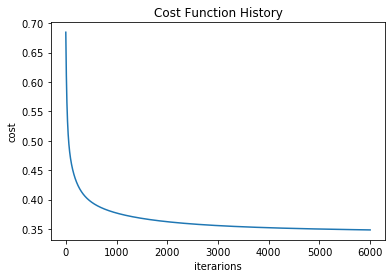

In [606]:
plt.title('Cost Function History')
plt.plot(cost_hist)
plt.xlabel('iterarions')
plt.ylabel('cost')
plt.show

### Reduced features result

In [649]:
theta_result_red, theta_hist_red, cost_hist_red = gradD(X_trainR_red, Y_train_red, m_train_red, n_red, 1, 0.1, 6000)

<function matplotlib.pyplot.show(*args, **kw)>

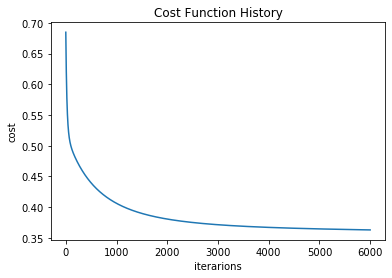

In [650]:
plt.title('Cost Function History')
plt.plot(cost_hist_red)
plt.xlabel('iterarions')
plt.ylabel('cost')
plt.show

## Plot Bias and Pole Distribution

## Accuracy of predition in persentage 

In [517]:
def accuracy(theta0r, thetaxr, X, Y, m):
    Y_predict = predict(theta0r, thetaxr, X, m)[0]
    acc = 100 - np.mean(np.abs(Y_predict - Y)) * 100
    return acc

### Accuracy of all feature training set preditions 

In [558]:
accuracy(theta_result[0], theta_result[1:], X_trainR, Y_train, m_train)

84.7262867963505

### Accuracy of all feature test set preditions 

In [559]:
accuracy(theta_result[0], theta_result[1:], X_testR, Y_test, m_test)

84.73059046307453

### Accuracy of reduced feature training set preditions 

In [652]:
accuracy(theta_result_red[0], theta_result_red[1:], X_trainR_red, Y_train_red, m_train_red)

84.77537576699937

### Accuracy of reduced feature test set preditions 

In [651]:
accuracy(theta_result_red[0], theta_result_red[1:], X_testR_red, Y_test_red, m_test_red)

84.74553601284023

In [524]:
cost(X_testR, Y_test, theta_result[0], theta_result[1:], m_test, 1)

0.3468345529512696

In [525]:
cost_hist[-1]

0.3456216952817596